## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Resources](#resources)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  This project is aimed at helping the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. The datasets for this project, were provided by Udacity as part of the Data Analsis Nanodegree Program.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Setting the seed to assure you get the same answers on quizzes as set up here.
random.seed(42)


Bad key savefig.frameon in file C:\Users\zariped\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\zariped\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\zariped\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlib

First, I will read in the `ab_data.csv` data, then store it in `df` and will take a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


The number of rows in the dataset are shown in the cell below.

In [3]:
df.shape
# there are 294478 rows and 5 columns in the dataset.

(294478, 5)

The number of unique users in the dataset:

In [4]:
df['user_id'].nunique()

290584

The proportion of users converted:

In [5]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match:

In [6]:
df[((df['landing_page'] == 'new_page') == (df['group'] == 'treatment')) == False].shape[0]
# There are 3893 times where `new_page` and `treatment` don't match.

3893

Let's see if any of the rows have missing values:

In [7]:
df.isnull().any(axis=1).sum()
# No missing values observed in any rows.

0

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. Therefore, I removed the rows where the landing_page and group columns don't match bacause I was not sure about the accuracy of the data and created a new dataframe that meets the specifications stated above. The new dataset is stored in df2.

In [8]:
df2 = df[((df['landing_page'] == 'new_page') == (df['group'] == 'treatment')) == True]

In [9]:
# Let's double Check and see if all of the correct rows were removed - this should be 0
df2[((df2['landing_page'] == 'new_page') == (df2['group'] == 'treatment')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

There is one **user_id** repeated in **df2**.  Let's look at the row information for the repeat **user_id**:

In [11]:
duplicate = df2[df2.duplicated(subset=['user_id'], keep=False)]
duplicate

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


I removed the second duplicate user_id to avoid counting the same user twice. It looks like this user visited the new_page twice in different dates.then kept the dataframe as **df2**.

In [12]:
df2.drop_duplicates(subset=['user_id'], inplace=True)

C:\Users\zariped\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
# Checking to make sure there are no more duplicates in df2 dataset.
df2.duplicated().any()

False

The probability of an individual converting regardless of the page they receive:

In [14]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, let's find out the probability they converted:

In [15]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, let's find out the probability they converted:

In [16]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

The probability that an individual received the new page:

In [17]:
df2['landing_page'].value_counts()/df2['landing_page'].count()

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

##### The probability of receiving the new page is 0.500062.

#### Base on the results from the above analysis, the indivuals in the treatment group had a conversion rate of 11.88% and the individuals in the control group had a conversion rate of 12.04%. Therefore, there is not sufficient evidencce to conclude that new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, let's consider to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, we can define our null and alternative hypotheses as follows.

$H_0:$ $P_{old}$ >= $P_{new}$ 

$H_1:$ $P_{old}$ < $P_{new}$ 

We assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore,we assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

The sample size used for each page is equal to the ones in **ab_data.csv**.  <br><br>

The sampling distribution is performed for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [18]:
df2.head(20)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


The **conversion rate** for $p_{new}$ under the null is shown below: 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The **conversion rate** for $p_{old}$ under the null is: <br><br>

In [20]:
# Since we're assuming that there is no difference in conversion based on the page under the null, the conversions for each page are the same.
p_old = df2['converted'].mean()
p_old

0.11959708724499628

The number of individuals in the treatment group, $n_{new}$, is:

In [21]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

The number of individuals in the control group, $n_{old}$, is:

In [22]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

We simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# new_page_converted is the number of 1's, simulating n_new transactions from a binomial distribution. 
new_page_converted = np.random.binomial(1, p_new, n_new)
# probability of having the new page
new_page_converted.mean()

0.11901452067992567

We simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# old_page_converted is the number of 1's, simulating n_old transactions from a binomial distribution. 
old_page_converted = np.random.binomial(1, p_old, n_old)
# probability of having the old page
old_page_converted.mean()

0.11914726654459848

Then we find $p_{new}$ - $p_{old}$ for our simulated values.

In [25]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()

p_new - p_old

-0.00013274586467280913

We then create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used above. Next we stored all 10,000 values in a NumPy array called **p_diffs**.

In [57]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

Plotting a histogram of the **p_diffs** is shown below:

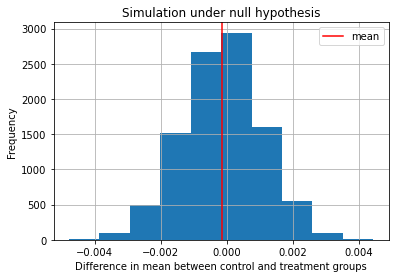

In [58]:
# Converting to numpy array for array based computation in the future
p_diffs = np.array(p_diffs)

# Plotting sampling distribution
plt.hist(p_diffs)
plt.title('Simulation under null hypothesis')
plt.xlabel('Difference in mean between control and treatment groups')
plt.ylabel('Frequency')
plt.grid()
plt.axvline(p_diffs.mean(), color='r', label='mean')
plt.legend();

Let's compute proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**?

In [59]:
actual_diffs = df2.converted[df2.group == 'treatment'].mean() - df2.converted[df2.group == 'control'].mean()
(p_diffs > actual_diffs).mean()

0.8831

#### We just computed the p-value in the cell above. The p-value is the probability of observing our statistic (or one more extreme in favor of the alternative) assuming the null hypothesis is true. Based on the significance level of $\alpha$ = 0.05, and the p-value= 0.883, we conclude that we fail to reject the null hypothesis as our p-value is much greater than $\alpha$ and quite large (close to 1). 

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. We calculate the number of conversions for each page, as well as the number of individuals who received each page.`n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

Now we use `stats.proportions_ztest` to compute our test statistic and p-value. [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [30]:
from statsmodels.stats.proportion import proportions_ztest
stat, p_value = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
stat, p_value 

(1.3109241984234394, 0.9050583127590245)

#### The stat (z_score), measured in standard deviation, represents how far from the mean our data point is. In this case, our data point is 1.311 standard deviation from the mean. The p-value of 0.905 is not the same as the p-value we computed in the previous section, 0.883 but based on both p-values, we can confidently say that we fail to reject the null hypothesis and that there is not enough evidence to conclude that the new page leads to more conversions.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

#### Since each row is either a conversion or no conversion, we can use the logistic regression approach in this case.

The goal in this section is to use **statsmodels** to fit the regression model that we have specified to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. We also need to add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['ab_page1', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

C:\Users\zariped\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\zariped\Anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


We use **statsmodels** to instantiate our regression model on the two columns created above, then we fit the model to predict whether or not an individual converts. 

In [32]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]) 
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:58:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

#### The summary of my model is shown in the cell above. Now let's analyze the results of our model summary:

In [33]:
1/np.exp(results.params[1])

1.0151020136964721

#### We can see that for every 1 point increase in ab_page, conversions are 1.015 times more likely, holding all other variables constant. The p-value of 0.190 for the ab_page also confirms that the landing page (ab_page) is not statistically significant.

#### We can see that our p-value from the logistic regression is different from the p-value that we calculated in part II. The reason being that the logistic regression is a two- tailed test and we are exploring only two possible outcomes.

#### The null and alternative hypotheses for our regression model are:
$H_0:$ $P_{old}$ = $P_{new}$ 

$H_1:$ $P_{old}$ $\neq$ $P_{new}$ 

Now, let's consider other things that might influence whether or not an individual converts.  There are two main advantages to analyzing data using a multiple regression model. The first is the ability to determine the relative influence of one or more predictor variables to the criterion value. The second advantage is the ability to identify outliers, or anomalies. Accordingly, multiple regression model is used to obtain findings with greater accuracy.
Any disadvantage of using a multiple regression model usually comes down to the data being used. Two examples of this are using incomplete data and falsely concluding that a correlation is a causation.
More details on this is provided [Here](https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html) .

#### One of the most important things to consider in our regression model is the duration of the experiment. The duration of our experiment is as follows:

In [42]:
# First we need to Change column type — from Object to DateTime.
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

C:\Users\zariped\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
from datetime import datetime as dt
df2['day'] = df2['timestamp'].dt.day
df2.dtypes
# We made a day column by calculating the delta between the timestamps in days.

C:\Users\zariped\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
intercept                int64
ab_page1                 uint8
ab_page                  uint8
day                      int64
dtype: object

In [44]:
# Now we can calculate the duration of the experiment in days.
duration = np.array(df2['day'].sort_values(ascending=True))
td = duration[-1] - duration[0]
td

22

#### As shown in the cell above, the duration of our experiment is 22 days which is quite short. It is recommended to increase the duration of this experiment to 1-2 months depending on the computational costs.

#### Another factor to consider in our regression model would be the country a user lives in. We will need to read in the **countries.csv** dataset and merge together our datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. Next we will investigate to see whether country had an impact on conversion.

In [45]:
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# We will join the 2 dataframes based on the user_id column that exists in both and will then get a list of the unique countries in our new dataframe.
country_df2 = df2.join(country_df.set_index('user_id'), on='user_id')
country_df2.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

#### Now we need to create dummy variables for these country columns.

In [48]:
country_df2[['CA','UK', 'US']] = pd.get_dummies(country_df2['country'])
country_df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,ab_page,day,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,21,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,12,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,11,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,8,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,21,US,0,0,1


In [49]:
country_df2['country'].value_counts()
# The most common country is the US.

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [50]:
country_df2['intercept'] = 1

log_mod = sm.Logit(country_df2['converted'], country_df2[['intercept', 'UK', 'US']]) 
results = log_mod.fit()
results.summary()
# We chose Canada as the baseline country.

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:               1.521e-05
Time:                        22:17:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [51]:
np.exp(results.params[1]), np.exp(results.params[2])

(1.0520274863403287, 1.041646846892443)

#### Based on the above results, the users from the UK are 1.05 times more likely to convert as compared to the users from Canada. Similary, the users from the US are 1.04 times more likely to convert as compared to the users from Canada. The p-values for UK and US are 0.074 and 0.129 and not statistically significant. Therefore, it appears that country does not have an impact on conversion.

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  To investigate that, we will create the necessary additional columns, and fit the new model.  

In [62]:
country_df2['US_ab_page'] = country_df2['US'] * country_df2['ab_page']
country_df2['UK_ab_page'] = country_df2['UK'] * country_df2['ab_page']

In [63]:
country_df2['intercept'] = 1

log_mod = sm.Logit(country_df2['converted'], country_df2[['intercept', 'US_ab_page', 'UK_ab_page']]) 
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 07 Dec 2020   Pseudo R-squ.:               1.082e-05
Time:                        10:32:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
US_ab_page    -0.0144      0.012     -1.155      0.248      -0.039       0.010
UK_ab_page     0.0112      0.018      0.626      0.532      -0.024       0.046
==============================================================================
"""

In [64]:
1/np.exp(-0.0144), np.exp(0.0112)

(1.0145041794607625, 1.011262954811771)

The results in the cell above show that for every unit of change in conversion of users from Canada, there will be a 1.014 change in conversion for the users from the US and a 1.011 change in the conversion of the users from the UK which show that there doesn't seem to be interaction between the conversion and country the user is from. The p-value for US_ab_page is 0.248 and the p-values for UK_ab_page is 0.532 respectively. Based on the null hypothesis, the difference in means would be zero and the alternative hypothesis states that the difference would not be zero. Since the p-values for US_ab_page and UK_ab_page are large, we fail to reject the null hypothesis and we can confidently conclude that the new treatment page, and the country the user is from, do not have a statistically significant impact on conversion. 

<a id='resources'></a>
### Part IV - Resources

#### Mastering Dates and Timestamps in Pandas (and Python in general)
https://towardsdatascience.com/mastering-dates-and-timestamps-in-pandas-and-python-in-general-5b8c6edcc50c
#### Extracting days from a numpy.timedelta64 value and calculating the duration
https://stackoverflow.com/questions/18215317/extracting-days-from-a-numpy-timedelta64-value
#### Join columns of another DataFrame
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
#### The Advantages & Disadvantages of a Multiple Regression Model
https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html